In [45]:
%%capture
import pandas as pd
import numpy as np
from datetime import timedelta
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import QuantileRegressor
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer
import importlib
for module in ['kooplearn', 'matplotlib']:
    try:
        importlib.import_module(module)
    except ImportError:
        %pip install {module}
import kooplearn
from sklearn.gaussian_process.kernels import RBF
from kooplearn.models import NystroemKernel
from kooplearn.data import traj_to_contexts
from sklearn.preprocessing import StandardScaler

#maybe, don't drop the price at date t because it might be useful at
#some fucking point

In [2]:
actual_path = os.getcwd()
os.chdir('/home/onyxia/work/Dynamical_system/data')
data_2019 = pd.read_csv('data_2019.csv',sep=';')
data_2020 = pd.read_csv('data_2020.csv',sep=';')
data_2021 = pd.read_csv('data_2021.csv',sep=';')
data_2022 = pd.read_csv('data_2022.csv',sep=';')
prices = pd.read_csv('France.csv')
os.chdir(actual_path)
%run functions.ipynb

/tmp/ipykernel_977/1494444423.py:5: DtypeWarning: Columns (36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2021 = pd.read_csv('data_2021.csv',sep=';')


In [3]:
whole_data = pd.concat([data_2019,data_2020,data_2021,data_2022])

In [4]:
whole_data = whole_data.reset_index(drop=True)

In [5]:
list_to_drop = ['Périmètre','Prévision J-1','Prévision J',
                ' Stockage batterie',
                'Déstockage batterie','Eolien terrestre',
                'Eolien offshore',
                'Unnamed: 40','Nature']
#the variables related to the batteries and both the ones 
#containing informations about offshore and onshore
#wind are deleted because they only contain NaN values

In [6]:
use_data = whole_data.drop(list_to_drop,axis=1).copy()

In [7]:
use_data = use_data.dropna()

In [8]:
use_data.loc[:, 'Heures'] = use_data['Heures'].apply(lambda x: f"{x}:00" if len(x.split(':')) == 2 else x)
use_data['Heures'] = pd.to_timedelta(use_data['Heures'])

In [9]:
use_data['date'] = pd.to_datetime(use_data['Date']) + use_data['Heures']

In [10]:
use_data.drop(['Heures'],axis=1,inplace=True)

In [11]:
prices_period = prices[prices['Datetime (Local)'] >= '2019-01-01 00:00:00'].copy()

In [12]:
prices_period

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
35063,France,FRA,2018-12-31 23:00:00,2019-01-01 00:00:00,51.00
35064,France,FRA,2019-01-01 00:00:00,2019-01-01 01:00:00,46.27
35065,France,FRA,2019-01-01 01:00:00,2019-01-01 02:00:00,39.78
35066,France,FRA,2019-01-01 02:00:00,2019-01-01 03:00:00,27.87
35067,France,FRA,2019-01-01 03:00:00,2019-01-01 04:00:00,23.21
...,...,...,...,...,...
87617,France,FRA,2024-12-29 17:00:00,2024-12-29 18:00:00,134.40
87618,France,FRA,2024-12-29 18:00:00,2024-12-29 19:00:00,133.72
87619,France,FRA,2024-12-29 19:00:00,2024-12-29 20:00:00,123.92
87620,France,FRA,2024-12-29 20:00:00,2024-12-29 21:00:00,118.59


In [13]:
prices_period.drop(['Country','ISO3 Code','Datetime (UTC)'],axis=1,inplace=True)

In [14]:
prices_period['Datetime (Local)'] = pd.to_datetime(prices_period['Datetime (Local)'])
whole_period = prices_period.merge(use_data,how='left',left_on='Datetime (Local)',
                                  right_on='date')

In [15]:
whole_period.drop('Datetime (Local)',axis=1,inplace=True)

In [16]:
whole_period.columns

Index(['Price (EUR/MWhe)', 'Date', 'Consommation', 'Fioul', 'Charbon', 'Gaz',
       'Nucléaire', 'Eolien', 'Solaire', 'Hydraulique', 'Pompage',
       'Bioénergies', 'Ech. physiques', 'Taux de Co2', 'Ech. comm. Angleterre',
       'Ech. comm. Espagne', 'Ech. comm. Italie', 'Ech. comm. Suisse',
       'Ech. comm. Allemagne-Belgique', 'Fioul - TAC', 'Fioul - Cogén.',
       'Fioul - Autres', 'Gaz - TAC', 'Gaz - Cogén.', 'Gaz - CCG',
       'Gaz - Autres', 'Hydraulique - Fil de l?eau + éclusée',
       'Hydraulique - Lacs', 'Hydraulique - STEP turbinage',
       'Bioénergies - Déchets', 'Bioénergies - Biomasse',
       'Bioénergies - Biogaz', 'date'],
      dtype='object')

In [17]:
whole_period.columns = ['price','date_wo_h','conso','fioul','coal','gas',
                       'nuclear','wind','sun','hydro','pump','bioenergy','physics',
                        'exchange_uk','exchange_sp','exchange_it','exchange_sw',
                        'exchange_gr','co2_rate','fioul_tac','fioul_cogen',
                        'fioul_other','gas_tac',
                       'gas_cogen','gas_ccg','gas_other','hydro_river','hydro_lake',
                       'hydro_turbine','bio_waste','bio_biomass','bio_biogas','date']

In [18]:
whole_period.dropna(inplace=True)

In [19]:
#whole_period['target_date'] = whole_period['date'] + timedelta(days=1)

In [20]:
%%capture
fig, ax = plt.subplots()
ax.plot(whole_period['date'],whole_period['price'])
ax.tick_params(axis='x', labelrotation=45)

In [21]:
whole_period['cos_day'] = whole_period['date'].dt.day.astype(float)
whole_period['sin_day'] = whole_period['date'].dt.day.astype(float)
whole_period['cos_month'] = whole_period['date'].dt.month.astype(float)
whole_period['sin_month'] = whole_period['date'].dt.month.astype(float)

In [22]:
whole_period['cos_day'] = cos_transformer(365).fit_transform(whole_period['cos_day'])
whole_period['cos_month'] = cos_transformer(12).fit_transform(whole_period['cos_month'])
whole_period['sin_day'] = sin_transformer(365).fit_transform(whole_period['sin_day'])
whole_period['sin_month'] = sin_transformer(12).fit_transform(whole_period['sin_month'])

In [23]:
%%capture
fig, ax = plt.subplots()
for i in ['cos_day','sin_day','cos_month','sin_month']:
    ax.plot(whole_period[f'{i}'],label=f'{i}')
    ax.legend()

In [24]:
#whole_period[whole_period['date'] < '2019-01-02 01:00:00' & whole_period['date'] <'2019-01-03 01:00:00' ]

In [25]:
whole_period['weekdays'] = whole_period['date'].dt.dayofweek
whole_period['weekend'] = np.zeros(whole_period.shape[0])
whole_period['not_weekend'] = np.zeros(whole_period.shape[0])
whole_period['date_wo_h'] = pd.to_datetime(whole_period['date_wo_h'])

In [26]:
for i in range(whole_period.shape[0]):
    if whole_period.loc[i,'weekdays'] == 5 or whole_period.loc[i,'weekdays'] == 6:
        whole_period.loc[i,'weekend'] = 1
    else:
        whole_period.loc[i,'not_weekend'] = 1

In [27]:
#we need to add the 2 days lagged of fossil fuel and nuclear production
#we cannot add what they call the announced availability because they don't 
#describe how they find it and on the majority of ressources concerning 
#the matter, we only have access to the effective production

In [28]:
whole_period['2_lags_coal'] = whole_period['coal'].shift(48)
whole_period['2_lags_fioul'] = whole_period['fioul'].shift(48)
whole_period['2_lags_gas'] = whole_period['gas'].shift(48)
whole_period['2_lags_nuke'] = whole_period['nuclear'].shift(48)
whole_period['target_price'] = whole_period['price'].shift(24)

In [29]:
whole_period.dropna(inplace=True) #we just loose two days

In [30]:
training_data = whole_period[whole_period['date_wo_h'].dt.year < 2022].copy()
test_data = whole_period[whole_period['date_wo_h'].dt.year == 2022].copy()
list_imp_hours = [3,8,13,18,23]

In [31]:
training_data.drop(['price'],axis=1,inplace=True)
test_data.drop(['price'],axis=1,inplace=True)

In [32]:
training_data = training_data[training_data['date'].dt.hour.isin(list_imp_hours)]
test_data = test_data[test_data['date'].dt.hour.isin(list_imp_hours)]
for_plots_date = test_data['date']
for_plots_train = training_data['date']
training_data.reset_index(inplace=True,drop=True)
test_data.reset_index(inplace=True,drop=True)

In [33]:
list_imp = list(training_data.columns) #list of features to keep for the koopman operator, as 
#it might be very computational demanding
list_imp.remove('date')
list_imp.remove('date_wo_h')
#['nuclear','2_lags_nuke','coal','exchange_uk','fioul','target_price']
y_train = np.array(training_data['target_price'])
y_test = np.array(test_data['target_price'])


#creation of the koopman train and test set
#different from the previous one as we have to
#keep all variables
koop_train = training_data[list_imp].copy()
koop_test = test_data[list_imp].copy()
koop_train['target_last'] = koop_train['target_price'].copy()
koop_test['target_last'] = koop_test['target_price'].copy()
koop_train.drop(['target_price'],axis=1,inplace=True)
koop_test.drop(['target_price'],axis=1,inplace=True)
scaler_koop = StandardScaler().fit(koop_train)
koop_train = scaler_koop.transform(koop_train)
koop_test = scaler_koop.transform(koop_test)

In [34]:
quantile_reg_05 = QuantileRegressor(quantile=0.05).fit(X=training_data,
                                                      y=y_train)
quantile_reg_95 = QuantileRegressor(quantile=0.95).fit(X=training_data,
                                                      y=y_train)

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>)

In [ ]:
predictions_05 = quantile_reg_05.predict(X=test_data)
predictions_95 = quantile_reg_95.predict(X=test_data)

In [ ]:
training_dates = pd.date_range(start='2019-01-03',end='2019-01-14',freq='h')
training_dates = training_dates[training_dates.hour.isin(list_imp_hours)]

In [ ]:
pred_array = np.zeros((0,2))
#need to find a way to keep a constant window
for day in training_dates:
    day_data = training_data[training_data['date_wo_h'] == day].copy()
    compteur = 0
    for hour in list_imp_hours:
        pred_array = np.zeros((1,2))
        accessible_data = day_data[day_data['date'].dt.hour <= hour]
        quantile_05_temp = QuantileRegressor(quantile=0.05).fit(X=accessible_data.drop(['date','date_wo_h','target_price']),
                                                                y=accessible_data['target_price'])
        quantile_95_temp = QuantileRegressor(quantile=0.95).fit(X=accessible_data.drop(['date','date_wo_h','target_price']),
                                                                y=accessible_data['target_price'])
        next_day = accessible_data.loc[4,'date'] + pd.offsets.Day(1) 
        #from here ok to gen because we always want
        #to predict the following day
        pred_0 = quantile_05_temp.predict(training_data[training_data['date'] == next_day])
        pred_1 = quantile_95_temp.predict(training_data[training_data['date'] == next_day])
        

In [ ]:
test_1 = training_dates[training_dates.hour.isin(list_imp_hours)]

In [ ]:
for i in range(test_1.shape[0]):
    print(test_1[i:i+10])

In [36]:
def make_training_windows_week(date_prediction):
    """
    Parameters
    -----------------------------------------------------------------

    date_prediction : date with hour,
    the date on which we want to predict the electricity consumption
    ----------------------------------------------------------------

    returns

    windows : a dataframe which rows correspond to the dates on which a classifier will train

    """
    date_prediction = pd.to_datetime(date_prediction)
    last_training_date = date_prediction - pd.Timedelta(days=1)
    first_training_date = date_prediction - pd.Timedelta(days=8)
    concerned_hours = [3,8,13,18,23]

    whole_training_dates = pd.date_range(start=first_training_date,end=last_training_date,freq='h')
    training_dates = whole_training_dates[whole_training_dates.hour.isin(concerned_hours)].copy()
    dict_windows = {}
    
    for i in range(len(concerned_hours)): #because we only want to predict the following day
        begin_train_seq = first_training_date+pd.Timedelta(days=i)
        end_train_seq = begin_train_seq + pd.Timedelta(days=7)
        set_i = pd.date_range(start=begin_train_seq,end=end_train_seq,freq='h')
        set_i = set_i[set_i.hour.isin(concerned_hours)]
        dict_windows[f'set_{i}'] = set_i

    windows = pd.DataFrame.from_dict(data=dict_windows)

    return windows

In [49]:
get_windows = make_training_windows_week('2019-01-29')

In [50]:
reg_05_dict = {}
reg_95_dict = {}

In [53]:
count = 0
for i in get_windows.columns:
    list_train = get_windows[i]
    training_set_part = training_data[training_data['date'].isin(list_train)]
    reg_05_dict[f'reg_{count}'] = QuantileRegressor(quantile=0.05).fit(X=training_set_part.drop(['target_price','date','date_wo_h'],axis=1),
                                                                  y=training_set_part['target_price'])
    reg_95_dict[f'reg_{count}'] = QuantileRegressor(quantile=0.95).fit(X=training_set_part.drop(['target_price','date','date_wo_h'],axis=1),
                                                                  y=training_set_part['target_price'])
    count += 1

In [54]:
reg_05_dict['reg_0'].predict(training_data[training_data['date_wo_h'] == pd.to_datetime('2019-01-29')].drop(['target_price','date','date_wo_h'],axis=1))

array([21.49972466, 45.78085481, 37.26866688, 53.8304037 , 46.64180103])

In [56]:
predictions_05 = np.zeros((0,5))
predictions_95 = np.zeros((0,5))
for i in range(count-1):
    to_pred = training_data[training_data['date_wo_h'] == pd.to_datetime('2019-01-29')].drop(['target_price','date','date_wo_h'],axis=1)
    predictions_05 = np.vstack((predictions_05,reg_05_dict[f'reg_{i}'].predict(to_pred)))
    predictions_95 = np.vstack((predictions_95,reg_95_dict[f'reg_{i}'].predict(to_pred)))

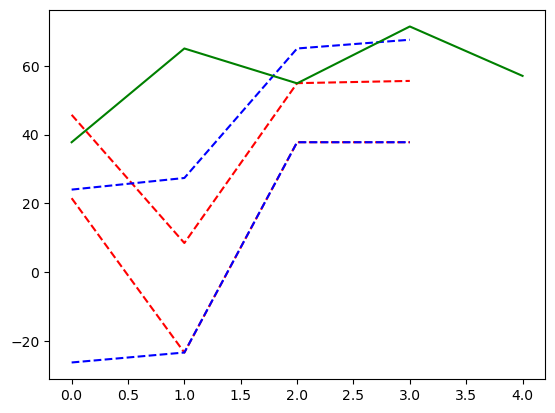

In [64]:
test = np.array(training_data[training_data['date_wo_h'] == pd.to_datetime('2019-01-29')]['target_price'])
for i in range(2):
    plt.plot(predictions_05[:,i],'r--')
    plt.plot(predictions_95[:,i],'b--')
plt.plot(test,'g-')

In [60]:
test

130    37.80
131    65.10
132    54.95
133    71.51
134    57.12
Name: target_price, dtype: float64